In [1]:
%matplotlib nbagg

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
#sys.path.append("../PETALO_DAQ_infinity/")
from SimLib import config_sim as conf
from SimLib import sipm_mapping as DAQ


In [2]:
def cutter(data,center,roi_odd=51):
    # Use roi with odd width
    data_m = np.roll(data,-center[1]+roi_odd//2,axis=1)
    data_out = np.copy(data_m[:,0:roi_odd])
    for i in range(data_m.shape[0]):
        for j in range(roi_odd):
            data_m[i,j] = 0
    data_m = np.roll(data_m,center[1]-roi_odd//2,axis=1)    
    return data_out,data_m

def paster(data,center,matrix,roi_odd=51):
    # Use roi with odd width
    data_m = np.roll(matrix,-center[1]+roi_odd//2,axis=1)
    data_m[:,0:roi_odd] = data
    data_m = np.roll(data_m,center[1]-roi_odd//2,axis=1)        
    return data_m


def levelset_cyl(data,iter=5,dt=1,level=[2.0,0.5]): 
    
    def F1_ls(i,params,dt=1):
        return params['A']*np.exp((dt*i)**2/(2*(params['sigma']**2)))
    
    # Level Set Stuff to find the contour
    for i in range(iter):
        dphi = np.array(np.gradient(data))
        dphi_norm = np.sqrt(np.sum(dphi**2, axis=0))
        data = data + dt * F1_ls(i,params={'A':0.25,'sigma':0.5},dt=0.1) * dphi_norm
        #data = data + dt * 0.5 * dphi_norm
    data_out = ((data<level[0])*(data>level[1]))*1.0  
    return data_out
    
def barycenter(event):
    roi_odd = event.shape[1]
    max_pos = np.unravel_index(np.argmax(event,axis=None),event.shape)
    # ROI windows centered around maximum
    linx=[i for i in range(-roi_odd//2+1,roi_odd//2+1,1)]
    liny=[i for i in range(event.shape[0])]#-event.shape[0]//2+1,event.shape[0]//2+1)]
    mx=np.array([linx for i in range(event.shape[0])])
    my=np.array([liny for i in range(roi_odd)])
    my = my.T
    # Mx computation
    A1x = mx*event
    A1y = my*event
    NormA = np.float(np.sum(event))
    if (NormA==0):
        x = 0
        y = 0
    else:
        x=np.float(np.sum(A1x))/NormA 
        y=np.float(np.sum(A1y))/NormA    
    
    out = {'E':np.array([x,y]),
           'max_SiPM':max_pos
          }
    return out

{u'ENVIRONMENT': {u'path_to_files': u'/home/viherbos/DAQ_DATA/NEUTRINOS/LESS_4mm/', u'n_files': 2, u'file_name': u'p_FR_infinity_4mm_', u'time_bin': 5, u'MC_file_name': u'full_ring_depth3cm_pitch4mm', u'out_file_name': u'daq_output_TEST', u'temperature': 300, u'n_events': 30000, u'MC_out_file_name': u'daq_output_TEST', u'ch_rate': 10000000.0}, u'SIPM': {u'size': [1, 3, 3]}, u'TOPOLOGY': {u'radius_ext': 1294, u'n_rows': 16, u'sipm_ext_row': 204, u'radius_int': 994, u'sipm_int_row': 157}, u'TOFPET': {u'TGAIN': 1, u'TE': 2, u'outlink_rate': 32500000.0, u'OUT_FIFO_depth': 256, u'n_channels': 64, u'IN_FIFO_depth': 4, u'MAX_WILKINSON_LATENCY': 5120}, u'L1': {u'L1_mapping_O': [6, 6, 5, 6, 6, 5, 6, 6, 5], u'frame_process': 3000000.0, u'L1_mapping_I': [], u'L1_outrate': 1000000000.0, u'n_asics': 16, u'map_style': u'striped_3', u'FIFO_L1b_depth': 128, u'FIFO_L1a_depth': 4096, u'buffer_size': 512, u'TE': 4}}
Number of SiPM : 5776 
Number of ASICS : 91 
Minimum Number of L1 : 6 
Available ASICS = 

<IPython.core.display.Javascript object>


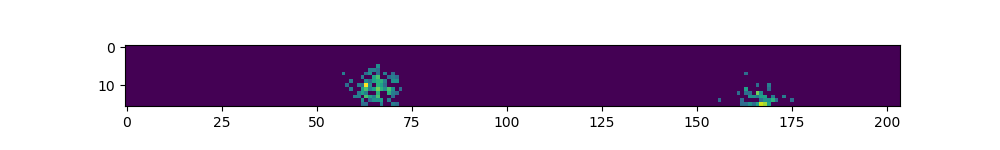

In [3]:
path = "./" #"/home/viherbos/DAQ_DATA/NEUTRINOS/LESS_4mm/"
jsonfilename = "OF_4mm_min"
filename     =  "daq_output_TEST_OF_4mm_min"
SIM_CONT=conf.SIM_DATA(filename=path+jsonfilename+".json",read=True)
data = SIM_CONT.data

dt = 1
it = 10
event = 20

L1_Slice, Matrix_I, Matrix_O, topo = DAQ.SiPM_Mapping(data,data['L1']['map_style'])
data = np.array(pd.read_hdf(path+filename+".h5",key='MC'), dtype = 'int32')

phi_o = np.zeros(Matrix_O.shape)
# Data Matrix Composition
for i in range(Matrix_O.shape[0]):
    for j in range(Matrix_O.shape[1]):
        phi_o[i,j] = data[event,int(Matrix_O[i,j]-1000)]

fig = plt.figure(figsize=(10,1.5))
plt.imshow((phi_o>0)*phi_o)

# LEVEL SET DEMO

DATA REQUIRED with LS: 87
DATA REQUIRED without LS: 206


<IPython.core.display.Javascript object>


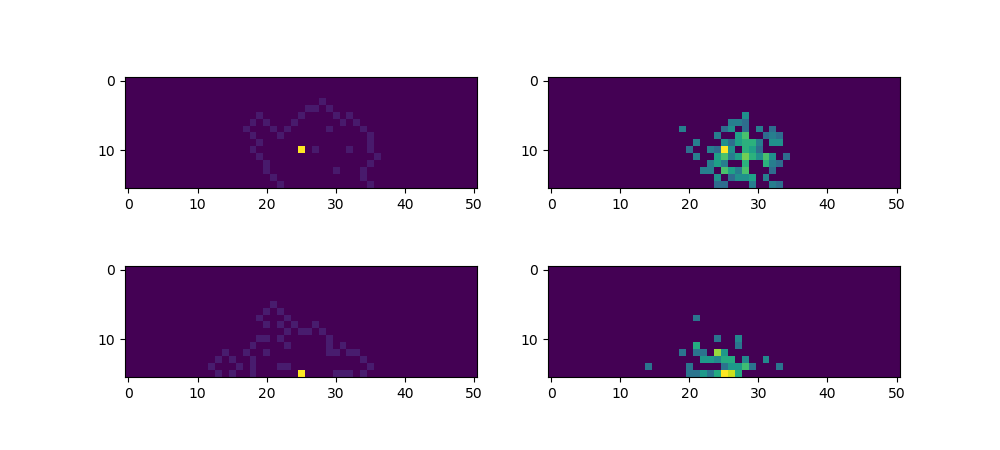

<IPython.core.display.Javascript object>


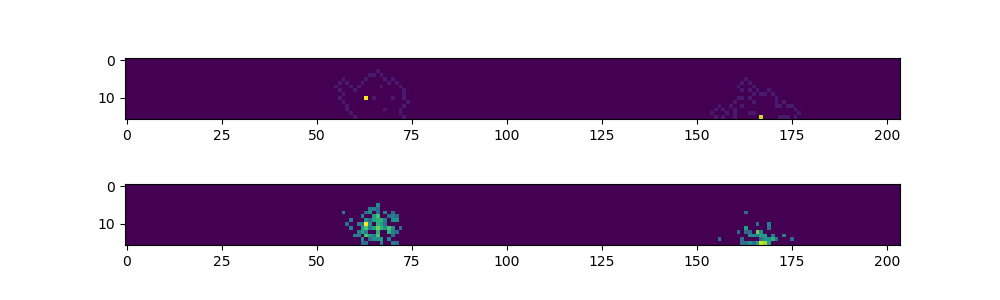

BARYCENTER 1 : x = 65.418947 // y = 10.597895
BARYCENTER 2 : x = 166.466063 // y = 13.235294
BARYCENTER_LS 1 : x = 64.211538 // y = 8.942308
BARYCENTER_LS 2 : x = 165.620690 // y = 12.120690


In [4]:
roi_odd = 51
# Find max maxvalue of both subevents       
max_pos = np.unravel_index(np.argmax(phi_o,axis=None),phi_o.shape)
event1, data_o = cutter(phi_o,max_pos,roi_odd)
max_pos2 = np.unravel_index(np.argmax(data_o,axis=None),phi_o.shape)
event2, data_o2 = cutter(data_o,max_pos2,roi_odd)

#Level Set Call
event1_ls = levelset_cyl( event1, iter=4 , dt=1, level=[2.0,0.5])
event2_ls = levelset_cyl( event2, iter=4 , dt=1, level=[2.0,0.5])

# Add MAX point to enhance barycenter calculation
event1_ls[max_pos[0] ,roi_odd//2]=phi_o[max_pos]
event2_ls[max_pos2[0],roi_odd//2]=phi_o[max_pos2]

# Barycenter computation
outxy1_ls = barycenter(event1_ls)
outxy2_ls = barycenter(event2_ls)
print("DATA REQUIRED with LS: %d" % (np.sum(event1_ls>0.0)+np.sum(event2_ls>0.0)+2))
outxy1 = barycenter(event1)
outxy2 = barycenter(event2)
print("DATA REQUIRED without LS: %d" % (np.sum(event1>0.0)*2+np.sum(event2>0.0)*2+2))

    
data_recover = np.zeros(phi_o.shape)
data_recover = paster(event1_ls,max_pos,data_recover,roi_odd=roi_odd)
data_recover = paster(event2_ls,max_pos2,data_recover,roi_odd=roi_odd)

# Plots
fig2 = plt.figure(figsize=(10,4.5))
ax1 = plt.subplot(221)
ax1.imshow(event1_ls)
ax2 = plt.subplot(223)
ax2.imshow(event2_ls)
ax1b = plt.subplot(222)
ax1b.imshow(event1)
ax2b = plt.subplot(224)
ax2b.imshow(event2)
fig2b = plt.figure(figsize=(10,3))
ax3 = plt.subplot(211)
ax3.imshow(data_recover)
ax4 = plt.subplot(212)
ax4.imshow(phi_o)

print("BARYCENTER 1 : x = %f // y = %f" % (outxy1['E'][0] + max_pos[1], outxy1['E'][1]))
print("BARYCENTER 2 : x = %f // y = %f" % (outxy2['E'][0] + max_pos2[1], outxy2['E'][1]))
print("BARYCENTER_LS 1 : x = %f // y = %f" % (outxy1_ls['E'][0] + max_pos[1], outxy1_ls['E'][1]))
print("BARYCENTER_LS 2 : x = %f // y = %f" % (outxy2_ls['E'][0] + max_pos2[1], outxy2_ls['E'][1]))
plt.show()

# CONTOUR MERGING

(16, 25) (16, 27)


<IPython.core.display.Javascript object>


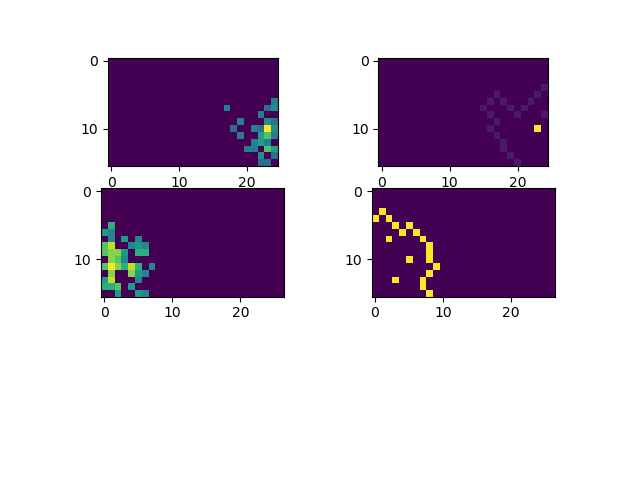

<IPython.core.display.Javascript object>


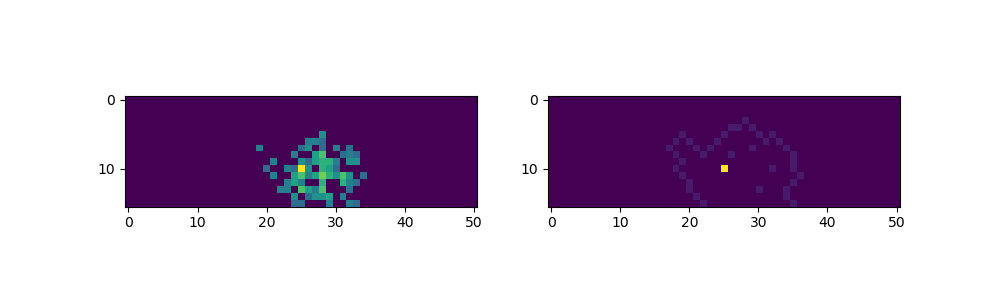

{'max_SiPM': (10, 25), 'E': array([  2.41894737,  10.59789474])}
{'max_SiPM': (10, 25), 'E': array([ 1.19230769,  8.90384615])}
BARYCENTER 1 : x = 25.418947 // y = 10.597895
BARYCENTER_LS 1 : x = 24.192308 // y = 8.903846


In [5]:
roi_odd = 51

patch1, data_o = cutter(phi_o,[8,52],25)
patch2, data_o = cutter(data_o,[8,78],27)
print patch1.shape, patch2.shape

#Level Set Call
patch1_ls = levelset_cyl( patch1, iter=4 )
patch2_ls = levelset_cyl( patch2, iter=4 )

# Add MAX point to enhance baricenter calculation
max_pos = np.unravel_index(np.argmax(patch1,axis=None),patch1.shape)
max_pos2 = np.unravel_index(np.argmax(patch2,axis=None),patch2.shape)
if (patch1[max_pos]>patch2[max_pos2]):
    patch1_ls[max_pos]=patch1[max_pos] 
else:
    max_pos = max_pos2
    patch2_ls[max_pos]=patch2[max_pos] 

# Get the recovered zone
recover    = np.concatenate((patch1,patch2),axis=1)
recover_ls = np.concatenate((patch1_ls,patch2_ls),axis=1)
event1, data_o = cutter(recover,max_pos,roi_odd)
event1_ls, data_o = cutter(recover_ls,max_pos,roi_odd)

# Barycenter computation
outxy = barycenter(event1)
outxy_ls = barycenter(event1_ls)

fig3 = plt.figure()
ax1 = plt.subplot(321)
ax1.imshow(patch1)
ax3 = plt.subplot(323)
ax3.imshow(patch2)
ax2 = plt.subplot(322)
ax2.imshow(patch1_ls)
ax4 = plt.subplot(324)
ax4.imshow(patch2_ls)

fig4 = plt.figure(figsize=(10,3))
ax1 = plt.subplot(121)
ax1.imshow(event1)
ax2 = plt.subplot(122)
ax2.imshow(event1_ls)

print outxy
print outxy_ls
print("BARYCENTER 1 : x = %f // y = %f" % (outxy['E'][0] + max_pos[1], outxy['E'][1]))
print("BARYCENTER_LS 1 : x = %f // y = %f" % (outxy_ls['E'][0] + max_pos[1], outxy_ls['E'][1]))

# NO LEVEL SET ONLY SENSOR POSITIONS

DATA REQUIRED with REDUCTION: 104
DATA REQUIRED without REDUCTION: 206


<IPython.core.display.Javascript object>


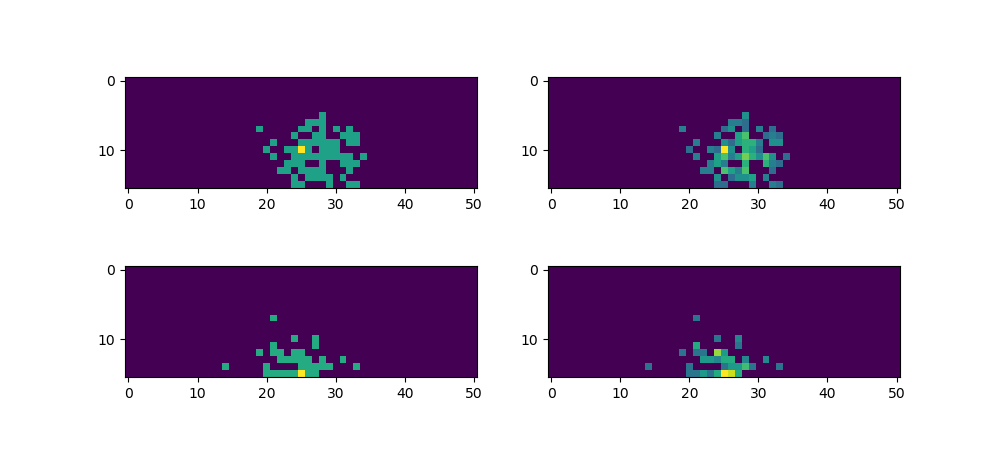

<IPython.core.display.Javascript object>


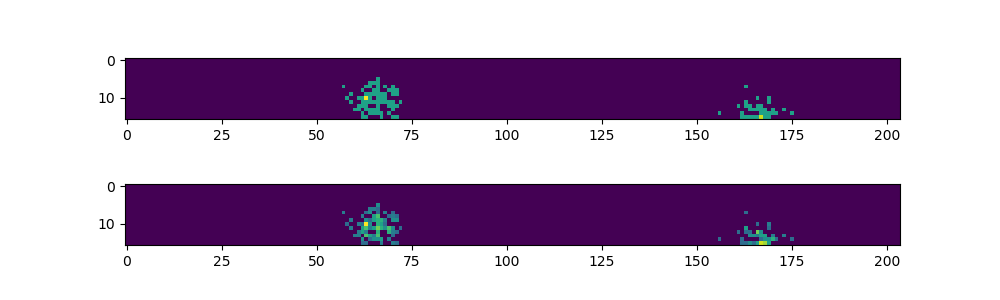

BARYCENTER 1 : x = 65.418947 // y = 10.597895
BARYCENTER 2 : x = 166.466063 // y = 13.235294
BARYCENTER_LS 1 : x = 65.422939 // y = 10.559140
BARYCENTER_LS 2 : x = 166.256506 // y = 13.126394


In [6]:
roi_odd = 51
cosmo_ct = 0.125
# Find max maxvalue of both subevents       
max_pos = np.unravel_index(np.argmax(phi_o,axis=None),phi_o.shape)
event1, data_o = cutter(phi_o,max_pos,roi_odd)
max_pos2 = np.unravel_index(np.argmax(data_o,axis=None),phi_o.shape)
event2, data_o2 = cutter(data_o,max_pos2,roi_odd)

#Level Set Call
event1_ls = levelset_cyl( event1, iter=0 ,level=[1000.0,0.5])
event2_ls = levelset_cyl( event2, iter=0 ,level=[1000.0,0.5])

# Add MAX point to enhance barycenter calculation
event1_ls[max_pos[0] ,roi_odd//2]=phi_o[max_pos]*cosmo_ct
event2_ls[max_pos2[0],roi_odd//2]=phi_o[max_pos2]*cosmo_ct

# Barycenter computation
outxy1_ls = barycenter(event1_ls)
outxy2_ls = barycenter(event2_ls)
outxy1 = barycenter(event1)
outxy2 = barycenter(event2)
print("DATA REQUIRED with REDUCTION: %d" % (np.sum(event1_ls>0.0)+np.sum(event2_ls>0.0)+2))
print("DATA REQUIRED without REDUCTION: %d" % (np.sum(event1>0.0)*2+np.sum(event2>0.0)*2+2))
    
data_recover = np.zeros(phi_o.shape)
data_recover = paster(event1_ls,max_pos,data_recover,roi_odd=roi_odd)
data_recover = paster(event2_ls,max_pos2,data_recover,roi_odd=roi_odd)

# Plots
fig5 = plt.figure(figsize=(10,4.5))
ax1 = plt.subplot(221)
ax1.imshow(event1_ls)
ax2 = plt.subplot(223)
ax2.imshow(event2_ls)
ax1b = plt.subplot(222)
ax1b.imshow(event1)
ax2b = plt.subplot(224)
ax2b.imshow(event2)
fig5b = plt.figure(figsize=(10,3))
ax3 = plt.subplot(211)
ax3.imshow(data_recover)
ax4 = plt.subplot(212)
ax4.imshow(phi_o)

print("BARYCENTER 1 : x = %f // y = %f" % (outxy1['E'][0] + max_pos[1], outxy1['E'][1]))
print("BARYCENTER 2 : x = %f // y = %f" % (outxy2['E'][0] + max_pos2[1], outxy2['E'][1]))
print("BARYCENTER_LS 1 : x = %f // y = %f" % (outxy1_ls['E'][0] + max_pos[1], outxy1_ls['E'][1]))
print("BARYCENTER_LS 2 : x = %f // y = %f" % (outxy2_ls['E'][0] + max_pos2[1], outxy2_ls['E'][1]))
plt.show()